# *Flattening the Curve*: Nonlinear Regression of COVID-19 Data

### Anton Zverev

Last edited: 05/03/20


---

In [37]:
import pandas as pd
import numpy as np
import inspect
from scipy import stats
from scipy import special
from math import sqrt
import time
import datetime

import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact
import plotly.offline as py
import plotly.express as px
import plotly.colors as pc
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
cf.set_config_file(offline=True, sharing=False, theme='ggplot');

# Data Importation & Cleaning

First, import raw data:

In [2]:
data_url_states = 'https://raw.githubusercontent.com/COVID19Tracking/covid-tracking-data/master/data/states_daily_4pm_et.csv'
data_url_global = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

raw_df_states = pd.read_csv(data_url_states) # state-by-state data
raw_df_global = pd.read_csv(data_url_global) # country-by-country data

I will reformat the global data into a new dataframe `global_cumulative` so that it's easier to use and intepret. I'll also only focus on the top 50 most affected countries.

In [3]:
raw_df_global.drop(columns=['Province/State','Lat','Long'],inplace=True)
raw_df_global.replace('US', 'United States',inplace=True)
raw_df_global = raw_df_global.groupby(by='Country/Region',as_index=True).agg(sum)
top_countries = raw_df_global.iloc[:,-1].sort_values(ascending=False).index[:50] # find top 50 countries

global_cumulative = raw_df_global.loc[top_countries,:].T # only take top countries, and transpose
global_cumulative.index.rename('date',inplace=True)
global_cumulative.columns.name = None
global_cumulative.index = pd.to_datetime(global_cumulative.index, format='%m/%d/%y') # fix timestamp
global_cumulative.sort_values(by='date',ascending=False,inplace=True)

global_cumulative.head(3)

,United States,Spain,Italy,United Kingdom,France,Germany,Turkey,Russia,Brazil,Iran,...,Bangladesh,Norway,Czechia,Dominican Republic,Colombia,Panama,Australia,South Africa,Egypt,Malaysia
date,,,,,,,,,,,,,,,,,,,,,
2020-05-02,1132539,216582,209328,183500,168518,164967,124375,124054,97100,96448,...,8790,7809,7755,7578,7285,7090,6799,6336,6193,6176
2020-05-01,1103461,213435,207428,178685,167305,164077,122392,114431,92202,95646,...,8238,7783,7737,7288,7006,6720,6778,5951,5895,6071
2020-04-30,1069424,213435,205463,172481,167299,163009,120204,106498,87187,94640,...,7667,7738,7682,6972,6507,6532,6766,5647,5537,6002


The raw state data is in a format that's hard to use, so I will convert it into a dataframe `states_cumulative` indexed by the date, with a separate column for each state:

In [4]:
states_list = raw_df_states['state'].unique() # list of state abbreviations (50 states + 5 territories + DC)

raw_df_states['date'] = pd.to_datetime(raw_df_states['date'], format='%Y%m%d') # fix timestamp
raw_df_states = raw_df_states[['date','state','positive']] #extract the columns I care about

states_cumulative = raw_df_states[raw_df_states['state']=='AK'][['date','positive']]
states_cumulative.reset_index(drop=True,inplace=True)

for s in states_list:
    state_data = raw_df_states[raw_df_states['state']==s]['positive']
    states_cumulative[s] = state_data.reset_index(drop=True)

states_cumulative.set_index('date',inplace=True) # index by date
states_cumulative.drop(columns='positive',inplace=True)
states_cumulative.fillna(value=0,inplace=True) # nan values will mess up the regression later
states_cumulative = states_cumulative.loc[:,(states_cumulative.iloc[0,:]>100).values] # remove states with <100 cases
states_list = states_cumulative.columns

states_cumulative.head()

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
date,,,,,,,,,,,,,,,,,,,,,
2020-05-02,365.0,7434.0,3372.0,8364.0,52197.0,15768.0,28764.0,4797.0,5038.0,35463.0,...,2588.0,12661.0,30522.0,4981.0,17731.0,886.0,14637.0,7660.0,1169.0,566.0
2020-05-01,364.0,7158.0,3321.0,7962.0,50442.0,15284.0,28764.0,4658.0,4918.0,34728.0,...,2525.0,11891.0,29229.0,4828.0,16901.0,879.0,14327.0,7314.0,1136.0,559.0
2020-04-30,355.0,7019.0,3255.0,7648.0,48917.0,14758.0,27700.0,4323.0,4734.0,33690.0,...,2449.0,10366.0,28087.0,4672.0,15846.0,866.0,14070.0,6854.0,1118.0,544.0
2020-04-29,355.0,6842.0,3192.0,7202.0,46500.0,14735.0,26767.0,4106.0,4655.0,33193.0,...,2373.0,10366.0,27054.0,4495.0,14961.0,862.0,13842.0,6520.0,1095.0,536.0
2020-04-28,351.0,6687.0,3111.0,6948.0,45031.0,13879.0,26312.0,3994.0,4575.0,32846.0,...,2313.0,10052.0,26171.0,4343.0,13794.0,862.0,13686.0,6289.0,1079.0,389.0


# Data Visualization

Besides the number of cumulative cases, it will also be helpful to look at the case increase per day. This is defined as the difference between the cumulative case counts on consecutive days. I'll store this data in `states_inc` and `global_inc`, and a smoothed (rolling 3-day average) version of the same data in `states_inc_rolling3` and `global_inc_rolling3`.

In [5]:
states_inc = states_cumulative.diff(periods=-1)
states_inc_rolling3 = (states_inc.shift(-1)+states_inc.shift(1)+states_inc)/3
states_inc_rolling3.dropna(inplace=True)

global_inc = global_cumulative.diff(periods=-1)
global_inc_rolling3 = (global_inc.shift(-1)+global_inc.shift(1)+global_inc)/3
global_inc_rolling3.dropna(inplace=True)

For regression analysis, we will need the dependent variable to be numeric, so I create `x_data`, which is the number of days that have passed since the beinning of the year. `x_data_global` is the same thing for the global dataframe.

In [6]:
x_data = states_cumulative.index.to_series().dt.dayofyear
x_data_global = global_cumulative.index.to_series().dt.dayofyear

Let's now visualize some of our data! States first:

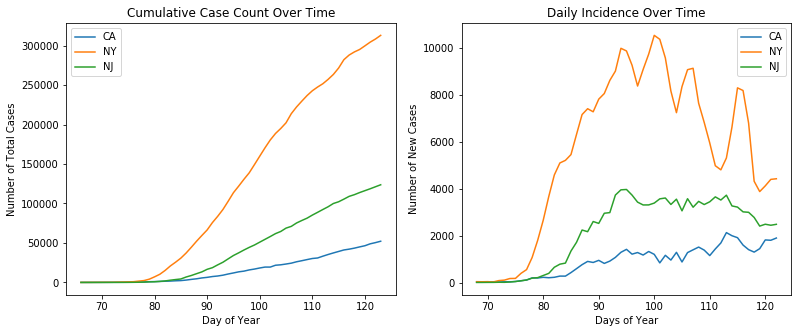

In [7]:
subset = ['CA','NY','NJ']

fig, ax = plt.subplots(1,2,figsize=(13,5))
ax[0].plot(x_data,states_cumulative[subset]);
ax[0].set(xlabel='Day of Year',ylabel='Number of Total Cases',title='Cumulative Case Count Over Time')
ax[0].legend(subset)

ax[1].plot(x_data[states_inc_rolling3.index],states_inc_rolling3[subset]);
ax[1].set(xlabel='Days of Year',ylabel='Number of New Cases',title='Daily Incidence Over Time')
ax[1].legend(subset)

plt.show()

And we can do the same for countries:

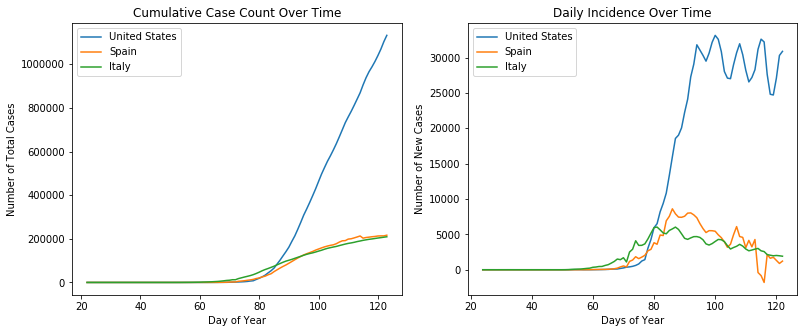

In [8]:
subset = global_cumulative.columns[:3]

fig, ax = plt.subplots(1,2,figsize=(13,5))
ax[0].plot(x_data_global,global_cumulative[subset]);
ax[0].set(xlabel='Day of Year',ylabel='Number of Total Cases',title='Cumulative Case Count Over Time')
ax[0].legend(subset)

ax[1].plot(x_data_global[global_inc_rolling3.index],global_inc_rolling3[subset]);
ax[1].set(xlabel='Days of Year',ylabel='Number of New Cases',title='Daily Incidence Over Time')
ax[1].legend(subset)

plt.show()

# Disease Modeling Basics

Before we go further let's clarify some terminology.

>**Daily incidence**: the number of new cases that are diagnosed every day. This represents how many new people are becoming infected every day. It's described in more detail [here](https://en.wikipedia.org/wiki/Incidence_(epidemiology)).

>**Cumulative case count**: the number of cumulative cases every day. This represents how many total people have been infected up until a certain day.

The graphs we just plotted above were the cumulative case count over time and the daily incidence over time, respectively. They are two different representations of the same data; the former is just the sum of the latter. Mathematically speaking, the cumulative case count at a certain day is the integral of the incidence up to that day. Equivalently, the incidence at a certain day is the derivative of the cumulative incidence on that day.

You may notice that the cumulative case counts look like they are increasing exponentially. In the early days of the outbreak, experts warned the public about such [exponential growth](https://en.wikipedia.org/wiki/Exponential_growth).

But wait! An important property of an exponential is that its derivative and integral is also an exponential. If the cumulative case count were exponential, then the daily incidence would be, too. But you can clearly see in the graphs above that the daily incidence first rises and then falls. It looks like a jagged hump. In fact, the daily incidence somewhat resembles a *bell curve*.

You may even have seen coronavirus graphs in the news that look something like this:

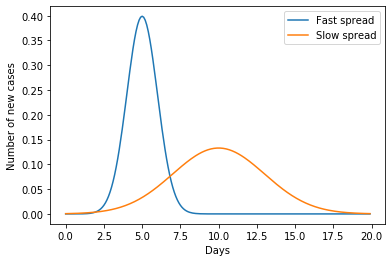

In [9]:
normal_1 = stats.norm(loc = 5, scale = 1) # gaussian with mean = 5, std = 1
normal_2 = stats.norm(loc = 10, scale = 3) # gaussian with mean = 10, std = 3
x = np.arange(0,20,0.1)
plt.plot(x,normal_1.pdf(x),x,normal_2.pdf(x)) # plot probability density functions
plt.xlabel('Days')
plt.ylabel('Number of new cases')
plt.legend(['Fast spread','Slow spread'])
plt.show()

Look's familiar right? Well, it turns out that when disease outbreaks happen, the daily incidence generally looks hump-shaped like that. The basic explanation is that in the beginning, very few people have the disease, but each person can infect several other people. The incidence increases rapidly as each new infected person infects many more people. Eventually, the incidence reaches a maximum. Let's define it:
>**Turning point, $t_i$**: the point at which the daily incidence reaches its peak, or "flattens out".

The turning point can be thought of as a saturation point, where so many people have been infected that the amount of new people available to be infected starts getting smaller. This process continues, and the daily incidence continues to decrease until it reaches zero: the outbreak is over.

Great! We have a rough idea of what daily incidence numbers should look like over time. What should the cumulative case counts look like? Well, it's the integral of a bell curve:

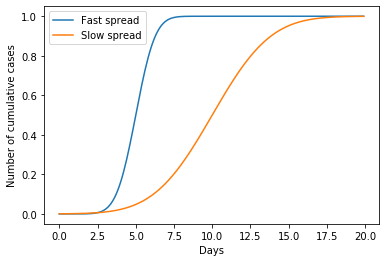

In [10]:
plt.plot(x,normal_1.cdf(x),x,normal_2.cdf(x)) # plot cumulative distribution functions
plt.xlabel('Days')
plt.ylabel('Number of cumulative cases')
plt.legend(['Fast spread','Slow spread'])
plt.show()

We see that the cumulative case curve is S-shaped and monotonically increasing – first rapid growth, then slow growth that approaches a plateau. Depending on how fast the spread of the disease is, the curve can be steeper or shallower. Also notice that the turning point, which was the maximum on the daily incidence graph, is the inflection point on the cumulative case count graph.

Now, let's get more precise with our math. What we have illustrated above are actually examples of distributions of continous variables, with the following analogies:
>Daily incidence over time can be thought of as a **probability density function [(PDF)](https://en.wikipedia.org/wiki/Probability_density_function)**, which we call $\phi(t)$.

>Cumulative case count over time can be thought of as a **cumulative distribution function [(CDF)](https://en.wikipedia.org/wiki/Cumulative_distribution_function)**, which we call $\Phi(t)$.

Generally speaking, for any hump-shaped PDF, we will observe a [sigmoidal](https://en.wikipedia.org/wiki/Sigmoid_function) CDF, because $\Phi(t)=\int_0^t\phi(\tau)d\tau$.

# Types of Models

The question now is the following: what mathematical function best describes our coronavirus data? We saw above that a bell curve seems like a reasonable guess for $\phi$, but there might be other functions that look similar. So, we need to find a few reasonable functions and define their PDFs as well as their **growth curves** (CDFs).

There are at least two mathematical functions that are suitable:

>**Normal** distribution [(link)](https://en.wikipedia.org/wiki/Normal_distribution), also called a Gaussian distribution or bell curve, defined by:

$$ \phi(t) = \frac{N}{s \sqrt{2 \pi}} e^{-\frac{1}{2}  (t-t_0)^2/s^2 } $$ 
$$ \Phi(t) = \frac{N}{2} + \frac{N}{2} \operatorname{erf}\left(\frac{t-t_0}{s \sqrt{2}}\right) $$

>**Logistic** distribution [(link)](https://en.wikipedia.org/wiki/Logistic_distribution), commonly used to model population growth in biology, defined by:

$$ \phi(t) = \frac{N}{4s} \operatorname{sech}^2 \left( \frac{t-t_0}{2s} \right) $$ 
$$ \Phi(t) = \frac{N}{1 + e^{-(t-t_0)/s}} $$


where $N$ is the final number of total cases, $t_0$ is a location parameter (equal to $t_i$ for these distributions), and $s$ is a scale parameter related to the steepness of the growth curve. The [error function](https://en.wikipedia.org/wiki/Error_function), $\operatorname{erf}(x)$, is a special function that appears commonly in statistics but has no closed form.

Let's visualize these distributions for $N=1$ and $t_i=10$. Note that the values of $s$ are different for each distribution because the maning of $s$ isn't directly comparable between the distributions.

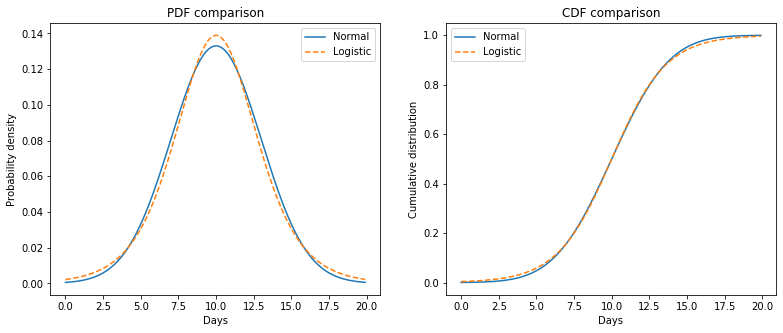

In [11]:
logistic_1 = stats.logistic(loc=10,scale=1.8)

fig, ax = plt.subplots(1,2,figsize=(13,5))
ax[0].plot(x,normal_2.pdf(x),'-',x,logistic_1.pdf(x),'--') # plot probability density functions
ax[0].set(xlabel='Days',ylabel='Probability density',title='PDF comparison')
ax[0].legend(['Normal','Logistic'])

ax[1].plot(x,normal_2.cdf(x),'-',x,logistic_1.cdf(x),'--') # plot cumulative distribution functions
ax[1].set(xlabel='Days',ylabel='Cumulative distribution',title='CDF comparison')
ax[1].legend(['Normal','Logistic'])
plt.show()

You can see that three distributions are very close to each other for this specific choice of parameters. The normal distribution has thinner tails while the logistic distribution has thicker tails.

These curves are great for describing the progression of an idealized disease. But one potential problem is that these models are perfectly *symmetric*, which means that the incidence increases just as quickly as it decreases. We don't necessarily know that to be the case; in fact, we might expect that the incidence should decrease more slowly than it increases, because towards the end of an outbreak it takes longer and longer to find new people to infect. This *right skew* is in fact what is observed in many epidemics.

So, we may want to test some growth curves that are asymmetric. Luckily, there are some generalizations of the distributions described above that can introduce skew:

>**Skew normal** distribution [(link)](https://en.wikipedia.org/wiki/Skew_normal_distribution), defined by:

$$ \Phi(t) = N \left[ \frac{1}{2} + \frac{1}{2} \operatorname{erf}\left(\frac{t-t_0}{s \sqrt{2}}\right) - 2 T \left(\frac{t-t_0}{s},a \right) \right] $$

>**Richards** curve [(link)](https://en.wikipedia.org/wiki/Generalised_logistic_function), a type of generalized logistic curve [used in some disease models](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3293463/), defined by:

$$ \Phi(t) = \frac{N}{\left(1 + e^{-(t-t_0)/s+\operatorname{ln}(a)} \right)^{1/a}} $$

>**Log logistic** distribution [(link)](https://en.wikipedia.org/wiki/Shifted_log-logistic_distribution), a different type of skewed logistic, defined by:

$$ \Phi(t) = \frac{N}{ 1 + \left(1+ \frac{a(t-t_0)}{s}\right)^{-1/a}} $$

>**Inverse Weibull** distribution [(link)](https://link.springer.com/article/10.1007/s00362-009-0271-3), used in several fields of engineering, defined by:

$$ \Phi(t) = N e^{-\left(\frac{s}{t-t_0}\right)^a} $$

>**Gompertz** curve [(link)](https://en.wikipedia.org/wiki/Gompertz_function), a special case of the generalized logistic [sometimes applied in biology](https://www.tandfonline.com/doi/pdf/10.1080/09712119.2016.1268965), defined by:

$$ \Phi(t) = N e^{-e^{-(t-t_0)/s}} $$

where $N$ is the final number of total cases, $t_0$ is a location parameter related to the turning point, $s$ is a scale parameter related to the rate of growth, and $a$ is a skewness parameter related to the asymmetry of the growth. The interpretations of $t_0$, $s$, and $a$ and their relations to $t_i$ vary depending on the model. The skew normal uses [Owen's T function](https://en.wikipedia.org/wiki/Owen%27s_T_function), $T(h,a)$, a special function that has no closed form.

Here are example plots for two of the skewed models:

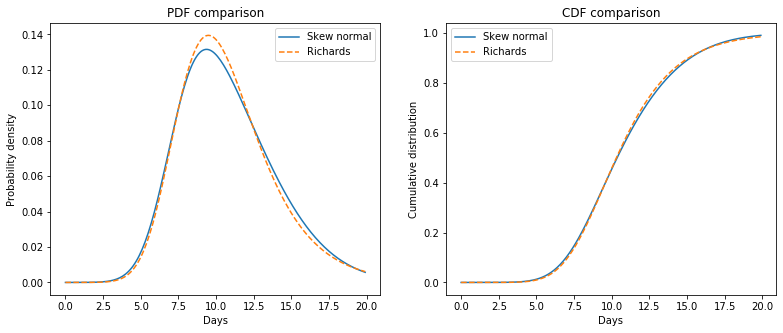

In [12]:
richards = stats.genlogistic(c=9,loc=4,scale=2.5)
skewnorm = stats.skewnorm(a=3,loc=7,scale=5)

fig, ax = plt.subplots(1,2,figsize=(13,5))
ax[0].plot(x,skewnorm.pdf(x),'-',x,richards.pdf(x),'--') # plot probability density functions
ax[0].set(xlabel='Days',ylabel='Probability density',title='PDF comparison')
ax[0].legend(['Skew normal','Richards'])

ax[1].plot(x,skewnorm.cdf(x),'-',x,richards.cdf(x),'--') # plot cumulative distribution functions
ax[1].set(xlabel='Days',ylabel='Cumulative distribution',title='CDF comparison')
ax[1].legend(['Skew normal','Richards'])
plt.show()

As with the symmetric models, there are subtle differences between the skewed models. This may mean that some models will fit the data more accurately than others, and that's what we want to find out!

We've now identified **7** different mathematical functions. The normal and logistic models are symmetric; the skew normal, Richards, log logistic, inverse Weibull, and Gompertz are asymmetric. We can now attempt to fit these to coronavirus case data.

**Note**: theoretically there should be no difference whether we fit daily incidence data to $\phi$ or cumulative case count data to $\Phi$. However, based on the initial graphs of real coronavirus data, you can see that daily incidence data is very noisy. It has a significantly higher noise-to-signal ratio than the cumulative case count data, so it will be more susceptible to overfitting and outlier influence. We should therefore perform our fits using the cumulative case count data, which is in line with standard practice in [disease modeling](https://www.sciencedirect.com/science/article/abs/pii/S1571064516300641).

# Data Fitting

First we need to define all the functions described above. Although `scipy.special` has built in objects for most of these models, calling them is much more computationally expensive than using `np.erf`, `np.exp` and `np.log`.
All of these $\Phi$ functions take an array of time points `t` as a first argument, followed by their distributon parameters (`N`, `t_i`, `s`, and/or `a`).

In [13]:
def normal(t, N, t_0, s):
    """
    Returns the normal growth curve evaluated at every time value in t.
    t_0 is the mean of the corresponding PDF and s is the standard deviation.
    """
    return (N/2 * (1 + special.erf((t - t_0)/(s*sqrt(2)))))

def logistic(t, N, t_0, s):
    """
    Returns the logistic growth curve evaluated at every time value in t.
    t_0 is the mean of the corresponding PDF and s*pi/sqrt(3) is the standard deviation.
    """
    return (N / (1 + np.exp(-(t - t_0)/s)))

def skewnorm(t, N, t_0, s, a):
    """
    Returns the skew normal growth curve evaluated at every time value in t.
    t_0 is related to the mean of the corresponding PDF and s is related to the standard deviation.
    Non-negative values of a correspond to right-skew, and a = 0 is equivalent to normal(t, N, t_0, s).
    """
    return N*(normal(t,1,t_0,s)-2*special.owens_t(((t-t_0)/s),a))

def richards(t, N, t_0, s, a):
    """
    Returns the Richards growth curve evaluated at every time value in t.
    t_0 is related to the mean of the corresponding PDF and s is related to the standard deviation.
    a must be positive, with a < 1 corresponding to right-skew. a = 1 is equivalent to logistic(t, N, t_0, s).
    """
    return N / np.power((1 + np.exp(np.log(a)-(t-t_0)*a/s)),(1/a))

def loglogistic(t, N, t_0, s, a):
    """
    Returns the log logistic growth curve evaluated at every time value in t.
    t_0 is related to the mean of the corresponding PDF and s is related to the standard deviation.
    a must be positive and always lead to right-skew. As a approaches 0, loglogistic approaches logistic(t, N, t_0, s).
    """
    cutoff = t_0 - s/a # the cdf is only necessarily nonnegative at t values above this cutoff
    cdf = np.array([N / (1 + (1 + a*(idx-t_0)/s)**(-1/a)) if idx > cutoff else 0 for idx in t])
    return cdf

def invweibull(t, N, t_0, s, a):
    """
    Returns the inverse Weibull growth curve evaluated at every time value in t.
    t_0 is related to the mean of the corresponding PDF and s is related to the standard deviation.
    a must be positive and always leads to right-skew.
    """
    return np.array([N * np.exp(-(s/(idx - t_0))**a) if idx > t_0 else 0 for idx in t])

def gompertz(t, N, t_0, s):
    """
    Returns the Gompertz growth curve evaluated at every time value in t.
    t_0 is related to the mean of the corresponding PDF and s is related to the standard deviation.
    """
    return N * np.exp(-np.exp(-(t-t_0)/s))

model_list = [normal, logistic, skewnorm, richards, loglogistic, invweibull, gompertz]

Next, we need a nonlinear `regression` function that will fit the data to whichever model is specified. We can use `scipy.least_squares` to find the parameter weights that minimize the loss (the square of the residuals). We also need a way of quantifying how closely the predictions match the actual data, so we must define the root-mean-squared error `rmse`.

In [14]:
def get_params(model):
    return list(inspect.signature(model).parameters.keys())[1:]

def regression(model,x_test,y_test):
    
    def residual(x, t, y):
        return model(t,*x) - y
    
    x0 = [y_test.max()*1.2,x_test.max()*0.8,1]
    x_min = [y_test.max(),x_test.min(),0]
    x_max = [np.inf,np.inf,np.inf]
    if len(get_params(model)) == 4:
        # append min, max, and starting values for the 'a' parameter
        x_min.append(0)
        if model.__name__ == 'skewnorm':
            x0.append(0.1)
            x_max.append(10) # personal choice
        elif model.__name__ == 'richards':
            x0.append(0.9)
            x_max.append(1)
        elif model.__name__ == 'loglogistic':
            x0.append(0.1)
            x_max.append(2) # personal choice
        elif model.__name__ == 'invweibull':
            x0.append(1.1)
            x_max.append(10) # personal choice
    
    res_lsq = least_squares(residual, x0, bounds=(x_min,x_max),
            ftol=1e-10, xtol=1e-10, gtol=1e-10, loss='linear', args=(x_test, y_test))
    return res_lsq.x # returns array of parameter values


In [15]:
def score_model(y, y_hat, k):
    sse = np.sum((y-y_hat)**2)
    n = len(y)
    rmse = np.sqrt(sse/n)
    aic = n*np.log(sse/n)+2*k
    bic = n*np.log(sse/n)+k*np.log(n)
    return rmse, aic, bic

Finally, we must define `fit_data` to iterate over every state or country and run `regression` on that region's incidence data. This function returns a dataframe with the predicted values of the fit parameters for each region, as well as the RMSE. The dataframe also includes figure handles to plots comparing the model to the actual data for each region. 

In [16]:
def fit_data(df,regions,region_type,model,x_test):
    start = time.time()
    param_names = get_params(model)
    k = len(param_names)
    param_vals = [[] for i in range(k)]
    rmse_vals = []
    #aic_vals = []
    bic_vals = []
    figs = []
    for item in regions:
        y_test = df[item].values
        params = regression(model,x_test,y_test)
        [param_vals[i].append(params[i]) for i in range(k)]
        y_pred = model(x_test,*params)
        rmse, aic, bic = score_model(y_test,y_pred,k)
        rmse_vals.append(rmse)
        #aic_vals.append(aic)
        bic_vals.append(bic)

        f = plt.figure()
        plt.plot(x_test,y_pred,'--')
        plt.plot(x_test,y_test)
        plt.xlabel('Day of Year')
        plt.ylabel('Cumulative Case Count')
        plt.title('Cases in '+item)
        plt.legend(['Model Fit','Actual Numbers'])
        figs.append(f)
        plt.close(f)
        
    fit_info = pd.DataFrame(index=regions,data={param_names[i]:param_vals[i] for i in range(k)})
    fit_info['fig'] = figs
    fit_info['rmse'], fit_info['bic'] = rmse_vals, bic_vals
    fit_info.index.rename(region_type,inplace=True)
    fit_info.sort_values(by='N',ascending=False,inplace=True)
    
    end = time.time()
    print(model.__name__ + ' finished in %.1f sec' % (end-start))
    
    return fit_info

np.seterr(all='ignore');

Now we can can go ahead and call `fit_data` on both the state data and the country data. Because we have several different fit functions, we need to run `fit_data` several times for every region. We can store one dataframe associated with each model type in the dictionaries `state_info` and `global_info`.

In [17]:
state_info = {m.__name__:fit_data(states_cumulative,states_list,'State',m,x_data.values) for m in model_list}

normal finished in 2.5 sec
logistic finished in 2.5 sec
skewnorm finished in 5.5 sec
richards finished in 7.8 sec
loglogistic finished in 20.7 sec
invweibull finished in 25.7 sec
gompertz finished in 2.9 sec


In [18]:
global_info = {m.__name__:fit_data(global_cumulative,top_countries,'Country',m,x_data_global.values) for m in model_list}

normal finished in 2.5 sec
logistic finished in 2.8 sec
skewnorm finished in 6.1 sec
richards finished in 6.9 sec
loglogistic finished in 23.0 sec
invweibull finished in 29.1 sec
gompertz finished in 2.6 sec


Here's what a few of the resulting dataframes look like:

In [19]:
state_info['gompertz'].head()

,N,t_0,s,fig,rmse,bic
State,,,,,,
NE,9.399085e+09,545.960370,158.115194,Figure(432x288),64.683780,495.844545
MN,4.858441e+09,647.220699,200.648287,Figure(432x288),133.297861,579.721326
IA,8.206753e+06,296.201560,89.912080,Figure(432x288),87.499235,530.890415
KS,4.578968e+05,239.657636,76.487276,Figure(432x288),104.262500,551.223093
NY,3.610919e+05,97.248313,13.692166,Figure(432x288),2120.049060,900.647892


In [20]:
global_info['gompertz'].head()

,N,t_0,s,fig,rmse,bic
Country,,,,,,
Brazil,5.640542e+06,211.110190,62.828004,Figure(432x288),782.439844,1373.007995
Ecuador,3.268906e+06,233.186138,71.139625,Figure(432x288),1201.318342,1460.474588
Qatar,2.715235e+06,243.134283,73.110483,Figure(432x288),148.844352,1034.466752
United States,1.508376e+06,103.298256,16.908293,Figure(432x288),7685.220429,1839.074004
Pakistan,8.123061e+05,212.886863,67.784742,Figure(432x288),181.170646,1074.560553


And here's what a few of the fits look like when plotted alongside the actual data:

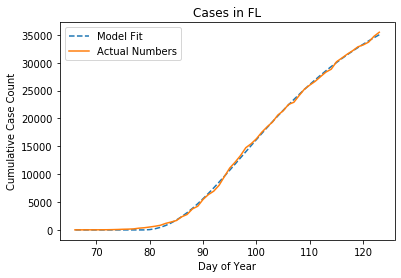

In [21]:
state_info['loglogistic'].loc['FL','fig']

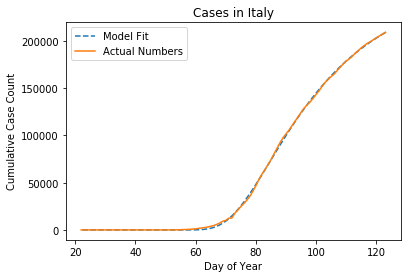

In [22]:
global_info['invweibull'].loc['Italy','fig']

# Model Comparison

Now, we need a way to compare the models to each other. We could try to look at every single plot and visually identify which of the models looks better. But that's not quantitative, and it's also not feasible for 5 models and 100 total regions.

Luckily, we have already computed the RMSE for each model fit for each region. The RMSE characterizes how closely the prediction matches the data, and the smaller the RSME the better the fit. Unfortunately, the magnitude of the RMSE might be different for each region because of the large difference in the magnitude of case counts. To handle this, we can [standardize](https://en.wikipedia.org/wiki/Standard_score) the RMSE scores across different regions by subtracting the average RMSE for a region and dividing by the standard deviation of the RMSE for that region. This is accomplished with `compare_models`:

In [23]:
def compare_models(fit_dict,criterion,standardize=True):
    c = pd.DataFrame([m[1][criterion] for m in fit_dict.items()],index=fit_dict.keys())
    if standardize:
        c = (c-c.mean())/c.std()
    return c.T

Now we can see the standard RMSE scores for both states and countries. Note that for each region, a positive score means that model was worse than the other models. A negative score means that the model was better than the rest.

In [24]:
state_rmses = compare_models(state_info,'rmse',standardize=True)
state_rmses.head(3)

,normal,logistic,skewnorm,richards,loglogistic,invweibull,gompertz
NE,-0.466027,-0.503332,-0.480692,-0.502381,0.160320,2.202672,-0.410561
MN,-0.397623,-0.404229,-0.404788,-0.401996,-0.283297,2.265640,-0.373707
IA,-0.432782,-0.277128,-0.433198,-0.430179,-0.231388,2.259028,-0.454354


In [25]:
global_rmses = compare_models(global_info,'rmse')
global_rmses.head(3)

,normal,logistic,skewnorm,richards,loglogistic,invweibull,gompertz
United States,0.90001,1.780869,-0.963977,-0.136331,-0.654163,-0.790012,-0.136395
Brazil,-0.33843,0.723338,-0.396918,-0.496209,-0.891071,1.961680,-0.562390
Ecuador,-0.03258,-0.708657,-0.032580,-0.708657,-0.704552,2.119562,0.067465


Clearly, different models do better for different regions. We can get a sense of how good each model is by plotting the distribution of scores with a [violin plot](https://en.wikipedia.org/wiki/Violin_plot).

In [34]:
cols = pc.DEFAULT_PLOTLY_COLORS


fig = make_subplots(rows=2, cols=1)
label = '%{customdata}: %{y:.2f}<extra></extra>'

for i,m in enumerate(rmse.columns):
    fig.add_trace(go.Violin(y=state_rmses[m], name=m, box_visible=False, meanline_visible=True, bandwidth=0.2,
                            hoveron='points', customdata = state_rmses.index.values,hovertemplate=label,
                            points='all',jitter=0.1,pointpos=0,line_color=cols[i]),row=1,col=1)
    
    fig.add_trace(go.Violin(y=global_rmses[m],name=m,box_visible=False,meanline_visible=True, bandwidth=0.2,
                            hoveron='points', customdata = global_rmses.index.values,hovertemplate=label,
                            points='all',jitter=0.1,pointpos=0,line_color=cols[i]),row=2,col=1)
    

fig.update_layout(width=800,height=700,title_text="Comparison of Models on State & Country Data",title_x=0.5,showlegend=False)
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='black', mirror=True)
fig.update_yaxes(title="Standard RMSE Score by State",row=1,col=1)
fig.update_yaxes(title="Standard RMSE Score by Country",row=2,col=1)
fig.show()


What's the verdict? Out of the symmetric models, the hyperbolic secant model is the worst, with high RMSE values for almost every region. The normal and logistic models seem decent. But the asymmetric models are significantly better! The skew normal model has a lower error than the normal model for every region, and the Richards model has a lower error than the logistic model. This lends credibility to the hypothesis that incidence data is not symmetric, and generally follows a right-skew distribution.

Both the skew normal and the Richards model seem good for a large number of regions, but for a few regions the skew normal model is significantly worse. Let's quantify the comparison by finding the average and median scores for each model:

# Visualizing Results

In [35]:
def show_region(dataset,model,region,month):
    
    if dataset=='state':
        df = state_info
        cum = states_cumulative
        x = x_data
    elif dataset=='country':
        df = global_info
        cum = global_cumulative
        x = x_data_global
    
    start = pd.Timestamp(x.index.values[-1])
    end = pd.to_datetime('2020-'+str(month)+'-28')
    delta = (end-start).days
    dates = [start+datetime.timedelta(n) for n in range(delta)]
    dates_numeric = np.arange(x.values[-1],x.values[-1]+delta,1)
    
    params = df[model].loc[region,:].values[:-3]
    y_pred = go.Scatter(name=model+' fit',x=dates,y=globals()[model](dates_numeric,*params),mode='lines',line=dict(dash="dash"))
    y_real = go.Scatter(name='actual cases to date',x=x.index,y=cum[region].values,mode='lines')
    layout = dict(xaxis=dict(title="Day of Year"),yaxis=dict(title="Cumulative Case Count in "+region),
                  width=700,height=400,margin=dict(t=30))
    
    fig = go.Figure([y_pred, y_real],layout=layout)
    fig.add_shape(name='current',type="line", x0=x.index[0], x1=x.index[0], y0=0, y1=params[0],
                  line=dict(width=1,dash="dot"))
    
    fig.update_xaxes(showgrid=True, showline=True, linewidth=1.5, linecolor='black', mirror=True)
    fig.update_yaxes(showgrid=False, showline=True, linewidth=1.5, linecolor='black', mirror=True)
    fig.show()


In [36]:
interact(show_region,dataset='state',model=list(state_info.keys()), 
                region=list(state_info.values())[0].index.sort_values().to_list(),
                month=widgets.IntSlider(value=5,min=4,max=9,step=1,description='thru month',continuous_update=False));

interactive(children=(Text(value='state', description='dataset'), Dropdown(description='model', options=('norm…

In [30]:
interact(show_region,dataset='country',model=list(global_info.keys()), 
                region=list(global_info.values())[0].index.sort_values().to_list(),
                month=widgets.IntSlider(value=5,min=4,max=9,step=1,description='thru month',continuous_update=False));

interactive(children=(Text(value='country', description='dataset'), Dropdown(description='model', options=('no…

In [39]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>